In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                   f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    pressure fields, and the baroclinic deformation radius for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    - R_d: Baroclinic deformation radius (meters).
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot(x_3d - x_c, y_3d - y_c)

    # Temperature field
    T = -2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0))
    sigma -= rho0

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor
    
    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    # radius of deformation
    drho_dz = -0.01
    N = np.sqrt(-g / rho0 * drho_dz)
    R_d = N * H / f0

    return U, V, sigma, T, S, P, x, y, z, R_d


In [3]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH = uu.shape
    u_x = (uu[2:, :] - uu[:-2, :]) / (2 * dx)
    u_y = (uu[:, 2:] - uu[:, :-2]) / (2 * dy)
    v_x = (vv[2:, :] - vv[:-2, :]) / (2 * dx)
    v_y = (vv[:, 2:] - vv[:, :-2]) / (2 * dy)
    
    u_x = np.concatenate((np.zeros((1, LENGTH)), u_x, np.zeros((1, LENGTH))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH)), v_x, np.zeros((1, LENGTH))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1)), u_y, np.zeros((WIDTH, 1))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1)), v_y, np.zeros((WIDTH, 1))), axis=1)
    
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow

def calc_lnam(x, y, uu, vv):
    # remeebr to input u and v transpose
    b = 1
    f = -1
    borders = b + 1
    L = np.zeros_like(uu)
    
    for i in range(borders, uu.shape[0] - borders):
        for j in range(borders, uu.shape[1] - borders):
            if not np.isnan(vv[i, j]):
                # Extract local values
                xlocal = x[i - b:i + b + 1, j - b:j + b + 1]
                ylocal = y[i - b:i + b + 1, j - b:j + b + 1]
                ulocal = uu[i - b:i + b + 1, j - b:j + b + 1]
                vlocal = vv[i - b:i + b + 1, j - b:j + b + 1]
                
                # Compute distances from centre
                center_idx = xlocal.shape[0]//2
  
                d_xcentre = xlocal - xlocal[center_idx, center_idx]
                d_ycentre = ylocal - ylocal[center_idx, center_idx]
                
                # Calculate cross and dot products
                cross = d_xcentre * vlocal - d_ycentre * ulocal
                dot = ulocal * d_xcentre + vlocal * d_ycentre
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                
                # Calculate L
                sumdp = np.sum(dot) + np.sum(produit)
                if sumdp != 0:
                    L[i, j] = np.sum(cross) / sumdp * np.sign(f)
    return L

# def calc_low(ow):

#     b = 1
#     borders = b + 1
#     LOW = np.full_like(ow)
    
#     for i in range(borders, ow.shape[0] - borders):
#         for j in range(borders, ow.shape[1] - borders):
#             if not np.isnan(ow[i, j]):

#                 ow_local = ow[i - b:i + b + 1, j - b:j + b + 1]
#                 LOW[i, j] = np.mean(ow_local)

#     return LOW

In [4]:
U, V, sigma, T, S, P, x, y, z, R_d = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _, R_d_tap = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _, R_d_tilt = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _, R_d_tilt_tap = calculate_eddy(taper_depth=400, alpha_1=alpha_1)



$$
R_d \approx 100\,\text{km}
$$

$$
dx = 5\,\text{km}
$$

$$
L_b = 2b \cdot dx
$$

$$
L_b < 1.2R_d
$$

$$
\Longrightarrow b = 11
$$
We can choose b = 1 becasue $2b\cdot dx=0.1R_d<1.2R_d$

In [5]:
print(R_d)
print(R_d_tap)
print(R_d_tilt)
print(R_d_tilt_tap)
                        

-119992.30491817962
-119992.30491817962
-119992.30491817962
-119992.30491817962


In [6]:
modelled_data = {
    'Eddy0':{
        'Name': 'E1', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': r'E1$_\text{tap}$', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'E2', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': r'E2$_\text{tap}$', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [7]:
from scipy.ndimage import maximum_filter, minimum_filter

WINDOW_SIZE = 5
SEARCH_RADIUS = 100000
VAR = 1  # 1 for cyclonic

# Grid and initialization
x, y = modelled_data['x'], modelled_data['y']
X, Y = np.meshgrid(x, y)
plot_data = {}

for eddy in eddies:
    plot_data[eddy] = {'df': pd.DataFrame(columns=['xc', 'yc', 'Depth'])}
    U_eddy, V_eddy = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    ic_pre, jc_pre = U_eddy.shape[0] // 2, U_eddy.shape[1] // 2
    bottom_flag = False

    for depth_lvl in range(U_eddy.shape[-1]):
        if bottom_flag:
            break
        
        u, v = U_eddy[:, :, depth_lvl], V_eddy[:, :, depth_lvl]
        lnam = calc_lnam(X, Y, u.T, v.T).T
        plot_data[eddy][f'lnam{depth_lvl}'] = lnam
        ow = calc_ow(u, v, x[1]-x[0], y[1]-y[0])
        plot_data[eddy][f'ow{depth_lvl}'] = ow

        IC, JC = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
        R = (np.hypot(ic_pre - IC, jc_pre - JC) * dx).T
        lnam = np.where(R <= SEARCH_RADIUS, lnam, np.nan)

        if VAR == 1:
            extrema = maximum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
        else:
            extrema = minimum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
        
        positions = (lnam == extrema)
        ic, jc = np.argwhere(positions).T

        if len(ic):
            R = (np.hypot(ic - ic_pre, jc - jc_pre) * dx).T
            idx = np.nanargmin(R)
            ic, jc = ic[idx], jc[idx]

            plot_data[eddy]['df'].loc[len(plot_data[eddy]['df'])] = {
                'xc': x[ic], 'yc': y[jc], 'Depth': z[depth_lvl]
            }
            ic_pre, jc_pre = ic, jc
        else:
            bottom_flag = True
    
    print(eddy)


Eddy0
Eddy1
Eddy2
Eddy3


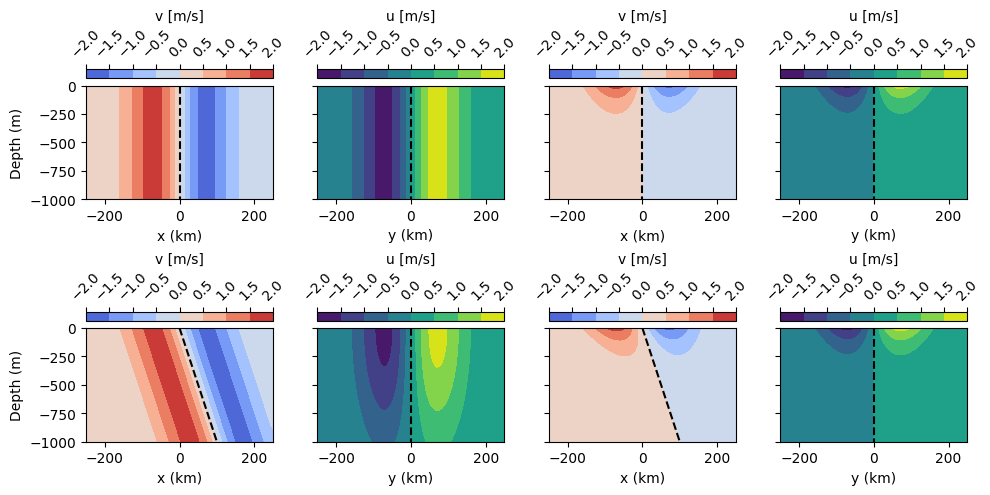

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
x = modelled_data['x']/1000
y = modelled_data['y']/1000
for i, ax_pair in enumerate(axs.reshape(-1, 2)):
    eddy = eddies[i]
    U = modelled_data[eddy]['U'][modelled_data[eddy]['U'].shape[0] // 2, :, :]
    V = modelled_data[eddy]['V'][:, modelled_data[eddy]['V'].shape[1] // 2, :]
    im1 = ax_pair[0].contourf(x, z, V.T, cmap='coolwarm')
    im2 = ax_pair[1].contourf(y, z, U.T)

    df = plot_data[eddy]['df']
    ax_pair[0].plot(df['xc']/1000, df['Depth'], color='k', linestyle='--')
    ax_pair[1].plot(df['yc']/1000, df['Depth'], color='k', linestyle='--')

    ax_pair[0].set_xlabel('x (km)')
    ax_pair[1].set_xlabel('y (km)')

    cbar1 = fig.colorbar(im1, ax=ax_pair[0], orientation='horizontal', location='top', label='v [m/s]')
    cbar2 = fig.colorbar(im2, ax=ax_pair[1], orientation='horizontal', location='top', label='u [m/s]')

    # Rotate colorbar ticks
    cbar1.ax.tick_params(axis='x', rotation=45)
    cbar2.ax.tick_params(axis='x', rotation=45)

axs[0, 0].set_ylabel('Depth (m)')
axs[1, 0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()

In [9]:
plot_data['Eddy3']['df']

,xc,yc,Depth
0,0.0,0.0,0.0
1,5000.0,0.0,-50.0
2,10000.0,0.0,-100.0
3,15000.0,0.0,-150.0
4,20000.0,0.0,-200.0
5,25000.0,0.0,-250.0
6,30000.0,0.0,-300.0
7,35000.0,0.0,-350.0
8,40000.0,0.0,-400.0
9,45000.0,0.0,-450.0


In [10]:
plot_data[eddy].keys()

dict_keys(['df', 'lnam0', 'ow0', 'lnam1', 'ow1', 'lnam2', 'ow2', 'lnam3', 'ow3', 'lnam4', 'ow4', 'lnam5', 'ow5', 'lnam6', 'ow6', 'lnam7', 'ow7', 'lnam8', 'ow8', 'lnam9', 'ow9', 'lnam10', 'ow10', 'lnam11', 'ow11', 'lnam12', 'ow12', 'lnam13', 'ow13', 'lnam14', 'ow14', 'lnam15', 'ow15', 'lnam16', 'ow16', 'lnam17', 'ow17', 'lnam18', 'ow18', 'lnam19', 'ow19', 'lnam20', 'ow20'])

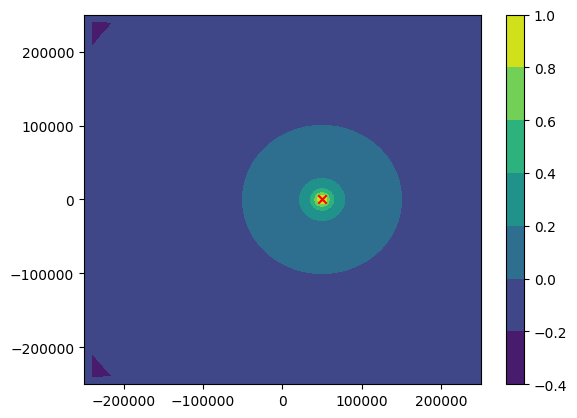

In [14]:
eddy = 'Eddy3'

depth_lvl = 10

lnam = plot_data[eddy]['lnam'+str(depth_lvl)]

df = plot_data[eddy]['df']

x = modelled_data['x']
y = modelled_data['y']
plt.contourf(x, y, lnam.T)
plt.colorbar()

plt.scatter(df.iloc[depth_lvl]['xc'], df.iloc[depth_lvl]['yc'], color='r', marker='x')
